Jacqueline Sanchez <br> 
July 01, 2024 <br>
<br>
COSC 3337 | Summer 2024 <br>
Homework 5

In [1]:
# libraries 
import pandas as pd
import numpy as np

# model importation
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# graphing tools
import seaborn as sns
import matplotlib.pyplot as plt

# tuning tools
from sklearn.model_selection import train_test_split, GridSearchCV

# metric/evaluation tools
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# time performance
import time

## Pre Processing Process

1. Import .data file

In [2]:
# load the dataset
letters_df = pd.read_csv('letter-recognition.data', header=None)
letters_df.columns = ['letter'] + [f'feature_{i}' for i in range(1, 17)]

# display the first 5 rows
print(letters_df.head())

  letter  feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0      T          2          8          3          5          1          8   
1      I          5         12          3          7          2         10   
2      D          4         11          6          8          6         10   
3      N          7         11          6          6          3          5   
4      G          2          1          3          1          1          8   

   feature_7  feature_8  feature_9  feature_10  feature_11  feature_12  \
0         13          0          6           6          10           8   
1          5          5          4          13           3           9   
2          6          2          6          10           3           7   
3          9          4          6           4           4          10   
4          6          6          6           6           5           9   

   feature_13  feature_14  feature_15  feature_16  
0           0           8         

2. checking for missing value

In [3]:
# method 1: 
print(letters_df.isna().sum())

# # methods 2: 
# print(letters_df.isnull().any())


if not letters_df.isnull().values.any():
    print("No missing data")
else:
    missing_count = letters_df.isnull().sum().sum()
    print(f"There are {missing_count} observations missing")

letter        0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
dtype: int64
No missing data


<span style = 'color:green'> 
Since there are no missing values in letters dataframe then we can proceed to the next steps without necessary imputations or dropping any column or observation row.

# 1. Preparing the data

### handling any extreme outliers and removing them

In [4]:
# Choose two letters for binary classification

# filter the dataset to only include rows with letters 'J' and 'N'
letters = ['J', 'N']
df_binary = letters_df[letters_df['letter'].isin(letters)].copy() # feature space 
df_binary['letter'] = df_binary['letter'].map({'J': 0, 'N': 1}) # target!

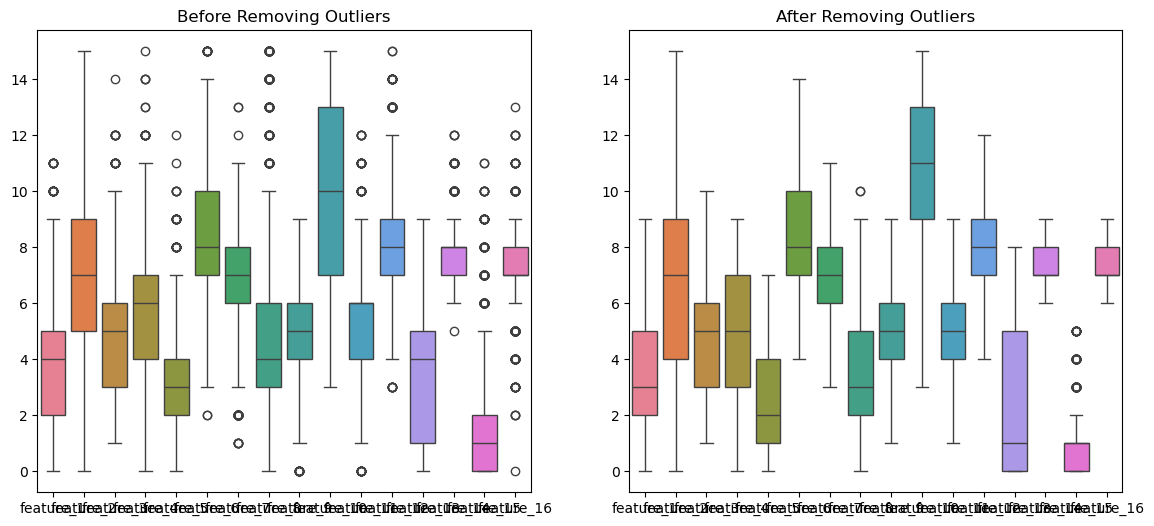

In [5]:
# ensuring there are no NaN values after mapping
assert df_binary['letter'].isna().sum() == 0, "there are NaN values in the target variable"

# find numeric columns (excluding 'letter')
numeric_columns = df_binary.columns[1:]

# finding outliers using the IQR method for numeric columns
Q1 = df_binary[numeric_columns].quantile(0.25)
Q3 = df_binary[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

# filter out outliers
df_filtered = df_binary[~((df_binary[numeric_columns] < (Q1 - 1.5 * IQR)) | (df_binary[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

# before removing 
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df_binary[numeric_columns])
plt.title('Before Removing Outliers')

# after removing 
plt.subplot(1, 2, 2)
sns.boxplot(data=df_filtered[numeric_columns])
plt.title('After Removing Outliers')

plt.show()

### preparing the data

In [6]:
# split the data into features and target
X = df_filtered.drop('letter', axis=1)
y = df_filtered['letter']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Train and Tune your models

## Training and Tuning Naive Bayes

### (a) Train and Tune Naive Bayes Classifier

In [7]:
# Naive Bayes Classifier
nb_model = GaussianNB()
start_time = time.time()
nb_model.fit(X_train, y_train)
nb_time = time.time() - start_time # getting the time it took for nb to tune to best params

# predicting based on our model  
nb_y_pred = nb_model.predict(X_test) 
nb_accuracy = accuracy_score(y_test, nb_y_pred)
nb_report = classification_report(y_test, nb_y_pred)

### (b) evaluate the Naive Bayes Classifier

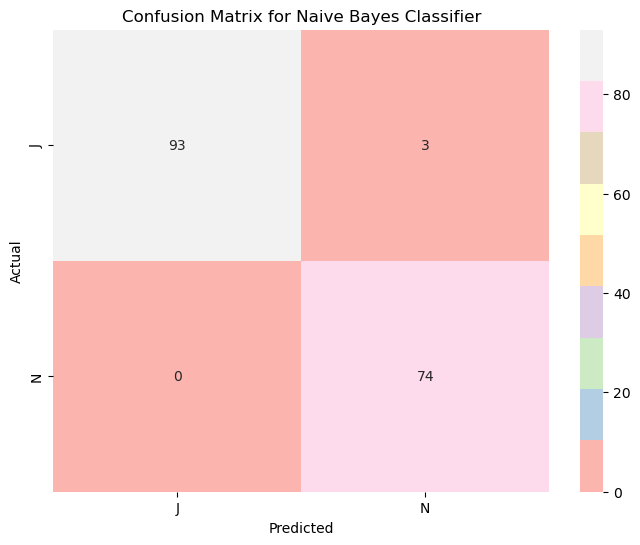

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        96
           1       0.96      1.00      0.98        74

    accuracy                           0.98       170
   macro avg       0.98      0.98      0.98       170
weighted avg       0.98      0.98      0.98       170



In [8]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, nb_y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Pastel1', xticklabels=letters, yticklabels=letters)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Naive Bayes Classifier')
plt.show()
print(nb_report)

## Training and tunning Logistic Regression Classifier

### (a) Train and Tune Logistic Regression Classifier

In [9]:
# Logistic Regression Classifier
lr_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
lr_grid = GridSearchCV(LogisticRegression(random_state=42), lr_params, cv=5, n_jobs=-1, return_train_score=True)
start_time = time.time()
lr_grid.fit(X_train, y_train)
lr_time = time.time() - start_time # getting the time for lr tunning

# predicting based on our model 
lr_best = lr_grid.best_estimator_ # best lr model found while performing GridSearchCV
lr_y_pred = lr_best.predict(X_test) # predictions on the test set 
lr_accuracy = accuracy_score(y_test, lr_y_pred) # calculating accuracy
lr_report = classification_report(y_test, lr_y_pred) # generating classification report 

### (b) Evaluate the Logistic Regression Classifier

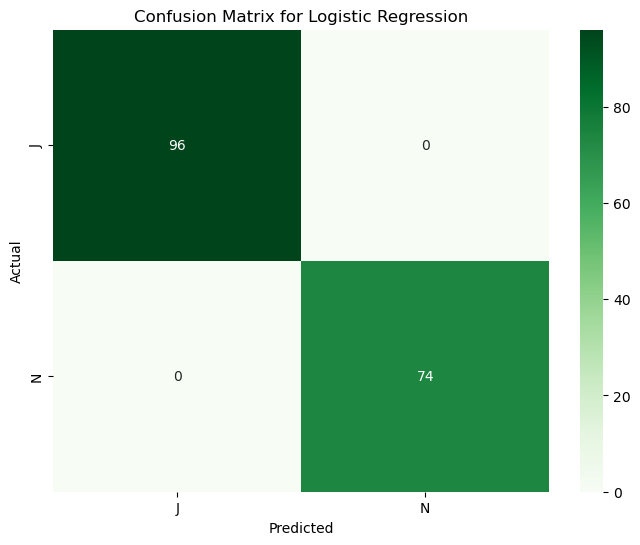

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        96
           1       1.00      1.00      1.00        74

    accuracy                           1.00       170
   macro avg       1.00      1.00      1.00       170
weighted avg       1.00      1.00      1.00       170



In [10]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, lr_y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=letters, yticklabels=letters)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()
print(lr_report)

## Training and tunning KNN Classifier

### (a)  Train and Tune KNN Classifier

In [11]:
# KNN Classifier
knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, n_jobs=-1, return_train_score=True)
start_time = time.time()
knn_grid.fit(X_train, y_train)
knn_time = time.time() - start_time # getting the time for knn tunning

# predicting based on our model 
knn_best = knn_grid.best_estimator_ 
knn_y_pred = knn_best.predict(X_test) 
knn_accuracy = accuracy_score(y_test, knn_y_pred)
knn_report = classification_report(y_test, knn_y_pred) 

### (b) Evaluate the KNN Classifier

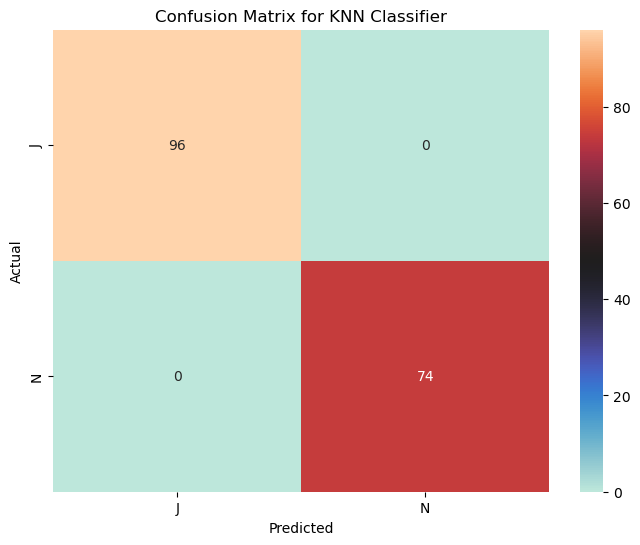

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        96
           1       1.00      1.00      1.00        74

    accuracy                           1.00       170
   macro avg       1.00      1.00      1.00       170
weighted avg       1.00      1.00      1.00       170



In [12]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, knn_y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='icefire', xticklabels=letters, yticklabels=letters)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for KNN Classifier')
plt.show()
print(knn_report)

### Evaluating and Comparing models (evidence)

In [13]:
# for Naive Bayes best Model
print(f"Naive Bayes Accuracy: {nb_accuracy}")
print(f"Naive Bayes Runtime: {nb_time} seconds")
print(f"Naive Bayes Classification Report:\n{nb_report}")

# for Logistic Regression best Model 
print(f"Logistic Regression Best Parameters: {lr_grid.best_params_}")
print(f"Logistic Regression Accuracy: {lr_accuracy}")
print(f"Logistic Regression Runtime: {lr_time} seconds")
print(f"Logistic Regression Classification Report:\n{lr_report}")

# for KNN best model 
print(f"KNN Best Parameters: {knn_grid.best_params_}")
print(f"KNN Accuracy: {knn_accuracy}")
print(f"KNN Runtime: {knn_time} seconds")
print(f"KNN Classification Report:\n{knn_report}")


Naive Bayes Accuracy: 0.9823529411764705
Naive Bayes Runtime: 0.003216981887817383 seconds
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        96
           1       0.96      1.00      0.98        74

    accuracy                           0.98       170
   macro avg       0.98      0.98      0.98       170
weighted avg       0.98      0.98      0.98       170

Logistic Regression Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Accuracy: 1.0
Logistic Regression Runtime: 1.326678991317749 seconds
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        96
           1       1.00      1.00      1.00        74

    accuracy                           1.00       170
   macro avg       1.00      1.00      1.00       170
weighted avg       1.00      1.00      1.00       170

K

# Performance Plots (evidence)

## Accuracy vs 'Epochs'

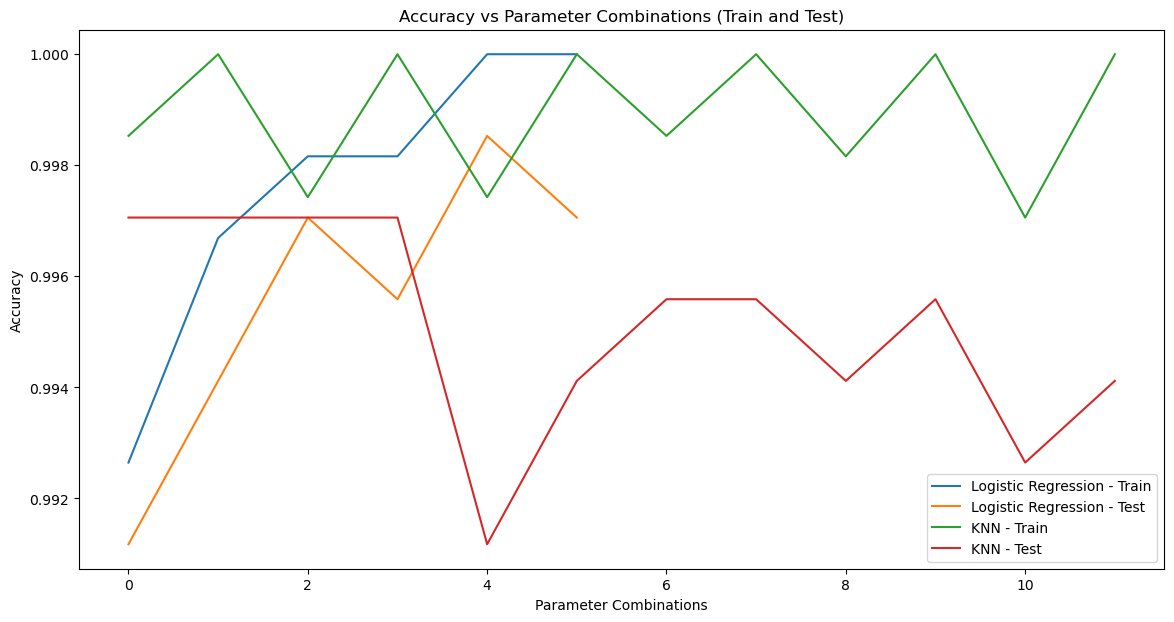

In [14]:
# Plotting accuracy vs parameter combinations (train and test)
plt.figure(figsize=(14, 7))
plt.plot(range(len(lr_grid.cv_results_['mean_test_score'])), lr_grid.cv_results_['mean_train_score'], label='Logistic Regression - Train')
plt.plot(range(len(lr_grid.cv_results_['mean_test_score'])), lr_grid.cv_results_['mean_test_score'], label='Logistic Regression - Test')
plt.plot(range(len(knn_grid.cv_results_['mean_test_score'])), knn_grid.cv_results_['mean_train_score'], label='KNN - Train')
plt.plot(range(len(knn_grid.cv_results_['mean_test_score'])), knn_grid.cv_results_['mean_test_score'], label='KNN - Test')
plt.xlabel('Parameter Combinations')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Parameter Combinations (Train and Test)')
plt.show()

<span style="color:green">
    
I noticed that logistic regression and Knn have demonstrated robust overall performance based on the confusion matrix and F1 score, as depicted on the earlier metrics but I also want analyze how well they performed while looking for the best parameters that optimized the model.
<br>
    
Logistic regression was able to identify the optimal set of parameters within the first few combinations generated using `paramGrid`. You can see that both the training and test sets exhibit similar trends within the range of the first 1-3 parameter combinations, as shown in the graph.
<br>
    
In contrast, KNN appears to require more parameter combinations to find the optimal set that best fits the model. This is evident from the greater variability in performance metrics when compared to logistic regression. KNN seems to need more extensive parameter tuning to achieve an optimized model that accurately reflects the variability in the actual values (test set).

## Pros and Cons

**Naive Bayes Classifier** 

Pros: Fast, simple, works well with small datasets. 

Cons: Assumes feature independence, may not perform well with highly correlated features. 


**Logistic Regression**

Pros: Interpretable, handles binary and multiclass classification, well-understood. 

Cons: Assumes linear relationship between features and outcome, sensitive to outliers. 

 
**KNN** 

Pros: Simple, non-parametric, can capture complex decision boundaries. 

Cons: Computationally expensive, sensitive to irrelevant features and the choice of k. 